In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import networkx as nx

In [2]:
import sys
sys.path.append('../../code')

import min_vertex_k_cut

In [3]:
hiv = pd.read_csv('../../data/raw/HIV.csv')
hiv['value'] = hiv['HIV_active']
hiv = hiv.drop(labels=['activity', 'HIV_active'], axis=1)
hiv

,smiles,value
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,0


In [4]:
smiles = hiv['smiles'].to_list()
threshold = 0.4

neighborhood_graph = min_vertex_k_cut.get_neighborhood_graph(smiles, threshold)
main_component, small_components = min_vertex_k_cut.get_main_component(neighborhood_graph)

old_nodes_to_new = dict(zip(main_component.nodes(), range(main_component.number_of_nodes())))
new_nodes_to_old = {v: k for k, v in old_nodes_to_new.items()}
main_component = nx.relabel_nodes(main_component, old_nodes_to_new)

[23:44:14] WARNING: not removing hydrogen atom without neighbors
[23:44:14] WARNING: not removing hydrogen atom without neighbors


In [5]:
for coarse_threhold in [0.90, 0.80, 0.70, 0.60, 0.50, 0.40]:
    coarsed_main_component, _ = min_vertex_k_cut.coarse_graph(main_component, coarse_threhold)
    node_degrees = list(dict(coarsed_main_component.degree()).values())
    print(coarse_threhold, len(coarsed_main_component), np.mean(node_degrees))

0.9 30924 20.355646100116413
0.8 28110 17.097260761294912
0.7 22320 12.994086021505376
0.6 16509 10.489793445999153
0.5 11399 9.024124923238881
0.4 6121 8.77797745466427


In [6]:
coarsed_main_component, node_to_cluster = min_vertex_k_cut.coarse_graph(main_component, 0.4)

In [7]:
model = min_vertex_k_cut.trisect_connected_graph(coarsed_main_component, part_min_frac=0.15, emphasis=1, max_mip_gap=0.5)

Total molecules: 31969
Min size of a partition: 4795
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 148951 (-18363) rows, 18363 (0) columns and 322380 (-36726) elements
Clp0030I 9 infeas 10261.694, obj 54273.647 - mu 0.17578287, its 62, 18363 interior
Clp0030I 14 infeas 644.26759, obj 39653.361 - mu 0.019527523, its 105, 18362 interior
Clp0030I 19 infeas 126.1624, obj 33296.82 - mu 0.0021692909, its 105, 18362 interior
Clp0030I 24 infeas 37.638431, obj 32224.632 - mu 0.00072302466, its 105, 18363 interior
Clp0030I 29 infeas 2.6323777, obj 31930.783 - mu 8.0320007e-05, its 105, 18363 interior
Clp0030I 34 infeas 0.12387534, obj 31930.365 - mu 8.9226604e-06, its 105, 18363 interior
Clp0030I 39 infeas 0.042125334, obj 31933.95 - mu 2.9739227e-06, its 105, 18363 interior
Clp0030I 44 infeas 0.0048232218, obj 31934.396 - mu 3.3036977e-07, its 105, 18363 interior
Cl

In [8]:
model.status

<OptimizationStatus.OPTIMAL: 0>

In [9]:
split = min_vertex_k_cut.process_trisect_results(model, coarsed_main_component, main_component, node_to_cluster)

[ 8153  4795  4795 14226]


In [11]:
len(main_component)

31969

In [13]:
first_idx = []
second_idx = []
third_idx = []

for S_idx, partition in enumerate(split):
    G_idx = new_nodes_to_old[S_idx]
    if partition == 0:
        first_idx.append(G_idx)
    if partition == 1:
        second_idx.append(G_idx)
    if partition == 2:
        third_idx.append(G_idx)

In [15]:
third_idx = third_idx[:len(first_idx)]

In [16]:
for component in small_components:
    i = np.argmin([len(first_idx), len(second_idx), len(third_idx)])
    if i == 0:
        first_idx.extend(component)
    if i == 1:
        second_idx.extend(component)
    if i == 2:
        third_idx.extend(component)

In [17]:
[len(first_idx), len(second_idx), len(third_idx)]

[7848, 7848, 7847]

In [18]:
part_first = hiv.iloc[first_idx]
part_second = hiv.iloc[second_idx]
part_third = hiv.iloc[third_idx]


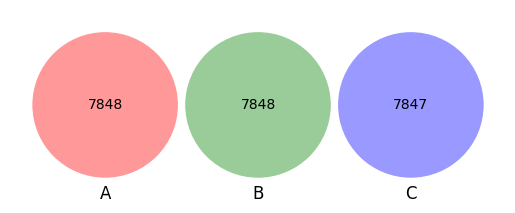

In [19]:
venn3([
    set(part_first['smiles'].tolist()),
    set(part_second['smiles'].tolist()),
    set(part_third['smiles'].tolist()),
])

In [20]:
train_1 = pd.concat([part_first, part_second])
test_1 = part_third.copy()

train_2 = pd.concat([part_first, part_third])
test_2 = part_second.copy()

train_3 = pd.concat([part_second, part_third])
test_3 = part_first.copy()

In [21]:
min_vertex_k_cut.test_split(train_1['smiles'], test_1['smiles'], threshold=0.4)

[00:03:36] WARNING: not removing hydrogen atom without neighbors
[00:03:36] WARNING: not removing hydrogen atom without neighbors


In [22]:
min_vertex_k_cut.test_split(train_2['smiles'], test_2['smiles'], threshold=0.4)

[00:03:54] WARNING: not removing hydrogen atom without neighbors
[00:03:54] WARNING: not removing hydrogen atom without neighbors


In [23]:
min_vertex_k_cut.test_split(train_3['smiles'], test_3['smiles'], threshold=0.4)

[00:04:08] WARNING: not removing hydrogen atom without neighbors
[00:04:08] WARNING: not removing hydrogen atom without neighbors


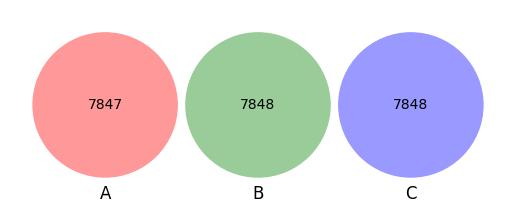

In [24]:
venn3([
    set(test_1['smiles'].tolist()),
    set(test_2['smiles'].tolist()),
    set(test_3['smiles'].tolist()),
])

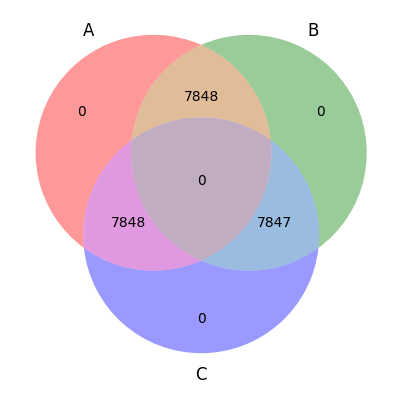

In [25]:
venn3([
    set(train_1['smiles'].tolist()),
    set(train_2['smiles'].tolist()),
    set(train_3['smiles'].tolist()),
])

In [27]:
train_1.to_csv('../../data/hi/hiv/train_1.csv')
train_2.to_csv('../../data/hi/hiv/train_2.csv')
train_3.to_csv('../../data/hi/hiv/train_3.csv')

In [28]:
test_1.to_csv('../../data/hi/hiv/test_1.csv')
test_2.to_csv('../../data/hi/hiv/test_2.csv')
test_3.to_csv('../../data/hi/hiv/test_3.csv')